In [ ]:
import numpy as np
import random
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef,
    roc_auc_score, roc_curve, auc
)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

TF version: 2.19.0


In [ ]:
def infer_label(header: str):
    """Infer species from VISTA-like headers."""
    h = header.lower()
    if h.startswith("human"):
        return "human"
    if h.startswith("mouse"):
        return "mouse"
    if "homo" in h or "hs" in h:
        return "human"
    if "mus" in h or "mm" in h:
        return "mouse"
    if "human" in h:
        return "human"
    if "mouse" in h:
        return "mouse"
    raise ValueError("Cannot infer label from header: " + header)


def load_fasta(path):
    sequences = []
    labels = []
    buf = []
    current_label = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if buf and current_label is not None:
                    sequences.append("".join(buf).upper())
                    labels.append(current_label)
                header = line[1:].strip()
                current_label = infer_label(header)
                buf = []
            else:
                buf.append(line.replace(" ", "").replace("\t", ""))
        if buf and current_label is not None:
            sequences.append("".join(buf).upper())
            labels.append(current_label)

    return sequences, labels

sequences_raw, labels = load_fasta("vista_sequences.fasta")
print("Loaded:", len(sequences_raw), "sequences")
print("Unique labels:", set(labels))

Loaded: 3408 sequences
Unique labels: {'mouse', 'human'}


In [ ]:

MAXLEN = 2000

def trim_center(seq, maxlen=MAXLEN):
    if len(seq) <= maxlen:
        return seq
    mid = len(seq) // 2
    start = mid - maxlen // 2
    return seq[start:start+maxlen]

sequences = [trim_center(s) for s in sequences_raw]
print("Max length after trimming:", max(len(s) for s in sequences))
print("Min length after trimming:", min(len(s) for s in sequences))


Max length after trimming: 2000
Min length after trimming: 188


In [ ]:
INTEGER = {"A":1.0, "C":3.0, "G":2.0, "T":4.0}
ATOMIC  = {"A":70.0, "C":58.0, "G":78.0, "T":66.0}
EIIP    = {"A":0.1260, "C":0.1340, "G":0.0806, "T":0.1335}

def encode_map(seq, mapping):
    return [mapping.get(nt, 0.0) for nt in seq]

def encode_bfdna(seq):
    c = Counter(seq)
    total = len(seq)
    freqs = {b: c.get(b, 0) / total for b in "ACGT"}
    return [freqs.get(nt, 0.0) for nt in seq]

def encode_sequences(seqs, scheme):
    if scheme == "integer":
        mapping = INTEGER
    elif scheme == "atomic":
        mapping = ATOMIC
    elif scheme == "eiip":
        mapping = EIIP
    elif scheme == "bfdna":
        mapping = None
    else:
        raise ValueError("Unknown scheme: " + scheme)

    X = np.zeros((len(seqs), MAXLEN), dtype=np.float32)

    for i, s in enumerate(seqs):
        if scheme == "bfdna":
            enc = encode_bfdna(s)
        else:
            enc = encode_map(s, mapping)
        L = min(len(enc), MAXLEN)
        X[i, :L] = enc[:L]
    mask = X != 0
    if np.any(mask):
        vmin, vmax = X[mask].min(), X[mask].max()
        if vmax > vmin:
            X[mask] = (X[mask] - vmin) / (vmax - vmin)

    return X[..., np.newaxis]

In [ ]:
NUCS = ["A", "C", "G", "T"]
K = 3 #3-8
KMER_LIST = ["".join(p) for p in itertools.product(NUCS, repeat=K)]
KMER_INDEX = {kmer:i for i,kmer in enumerate(KMER_LIST)}

def kmer_vector(seq, k=K):
    vec = np.zeros(len(KMER_LIST), dtype=np.float32)
    if len(seq) < k:
        return vec
    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        if any(ch not in "ACGT" for ch in kmer):
            continue
        idx = KMER_INDEX[kmer]
        vec[idx] += 1
    total = vec.sum()
    if total > 0:
        vec /= total
    return vec

def basic_composition_features(seq):
    seq = "".join(ch for ch in seq if ch in "ACGT")
    L = len(seq)
    if L == 0:
        return np.zeros(4, dtype=np.float32)
    counts = Counter(seq)
    gc = (counts.get("G",0) + counts.get("C",0)) / L
    at = (counts.get("A",0) + counts.get("T",0)) / L
    cpg = seq.count("CG") / L
    length_norm = L / MAXLEN
    return np.array([gc, at, cpg, length_norm], dtype=np.float32)

def extract_features(seqs):
    feats = []
    for s in seqs:
        kv = kmer_vector(s)
        comp = basic_composition_features(s)
        feats.append(np.concatenate([kv, comp]))
    feats = np.stack(feats, axis=0)
    return feats

X_feats_raw = extract_features(sequences)
print("Feature shape:", X_feats_raw.shape)


Feature shape: (3408, 68)


In [ ]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(labels)  # 0/1 for human/mouse

idx = np.arange(len(y))

train_idx, test_idx = train_test_split(
    idx, test_size=0.25, random_state=SEED, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.25/0.75, random_state=SEED, stratify=y[train_idx]
)

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))

scaler = StandardScaler()
X_feats_train = scaler.fit_transform(X_feats_raw[train_idx])
X_feats_val   = scaler.transform(X_feats_raw[val_idx])
X_feats_test  = scaler.transform(X_feats_raw[test_idx])

feat_dim = X_feats_train.shape[1]
print("Feature dim:", feat_dim)

Train: 1704 Val: 852 Test: 852
Feature dim: 68


In [ ]:
def build_hybrid_model(input_seq_shape, feature_dim):
    seq_input = layers.Input(shape=input_seq_shape, name="seq_input")

    x = layers.Conv1D(64, 7, padding="same", activation="selu")(seq_input)
    x = layers.MaxPooling1D(4)(x)           

    x = layers.Conv1D(128, 5, padding="same", activation="selu")(x)
    x = layers.MaxPooling1D(4)(x)            

    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True)
    )(x)
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True)
    )(x)
    x = layers.Bidirectional(
        layers.GRU(32, return_sequences=True)
    )(x)

    attn_out = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_out])  # residual connection
    x = layers.LayerNormalization()(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)
    seq_emb = layers.Dense(128, activation="selu")(x)

    #Features
    feat_input = layers.Input(shape=(feature_dim,), name="feat_input")
    f = layers.Dense(64, activation="selu")(feat_input)

    h = layers.Concatenate()([seq_emb, f])
    h = layers.Dense(128, activation="selu")(h)
    h = layers.Dropout(0.3)(h)
    h = layers.Dense(64, activation="selu")(h)

    out = layers.Dense(1, activation="sigmoid")(h)

    model = models.Model(inputs=[seq_input, feat_input], outputs=out)
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

In [ ]:
def compute_metrics_binary(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob >= thresh).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sp = tn / (tn + fp) if (tn + fp) > 0 else 0
    rc = tp / (tp + fn) if (tp + fn) > 0 else 0

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    csi  = prec + rc - 1
    gmean = np.sqrt(sp * rc) if sp * rc > 0 else 0
    mcc  = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rc,
        "f1": f1,
        "CSI": csi,
        "G-mean": gmean,
        "MCC": mcc,
        "Kappa": kappa,
        "AUC": auc_score,
        "CM": cm
    }

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=label_enc.classes_,
                yticklabels=label_enc.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



Encoding: integer


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 2000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 500, 64)   │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 500, 128)  │     41,088 │ max_pooling1d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 125, 128)  │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_34    │ (None, 125, 128)  │     74,496 │ max_pooling1d_35… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_35    │ (None, 125, 128)  │     74,496 │ bidirectional_34… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_36    │ (None, 125, 64)   │     31,104 │ bidirectional_35… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     33,216 │ bidirectional_36… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 125, 64)   │          0 │ bidirectional_36… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 192)       │          0 │ dense_85[0][0],   │
│ (Concatenate)       │                   │            │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 128)       │     24,704 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 128)       │          0 │ dense_87[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 300,801 (1.15 MB)

 Trainable params: 300,801 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6343 - auc: 0.6790 - loss: 0.7877 - val_accuracy: 0.7113 - val_auc: 0.8669 - val_loss: 0.5553
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7479 - auc: 0.8363 - loss: 0.4960 - val_accuracy: 0.7359 - val_auc: 0.8437 - val_loss: 0.5446
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7945 - auc: 0.8671 - loss: 0.4469 - val_accuracy: 0.7664 - val_auc: 0.8663 - val_loss: 0.4905
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7965 - auc: 0.8821 - loss: 0.4259 - val_accuracy: 0.8005 - val_auc: 0.8796 - val_loss: 0.4390
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8281 - auc: 0.8962 - loss: 0.3995 - val_accuracy: 0.8005 - val_auc: 0.8780 - val_loss: 0.4329
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8183 - auc: 0.8961 - loss: 0.3996 - val_accuracy: 0.7899 - val_auc: 0.8749 - val_loss: 0.4390
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms

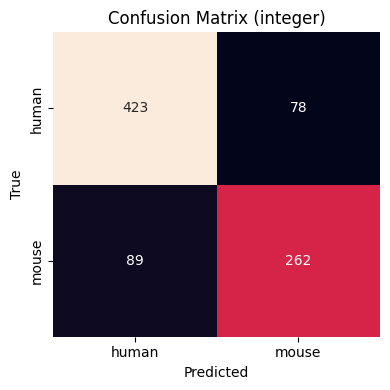

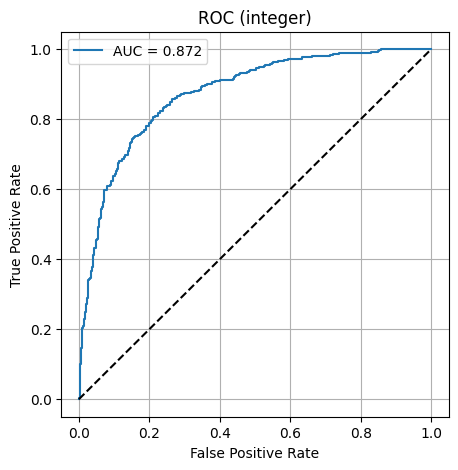



Encoding: atomic


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 2000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 500, 64)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 500, 128)  │     41,088 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 125, 128)  │          0 │ conv1d_37[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_37    │ (None, 125, 128)  │     74,496 │ max_pooling1d_37… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_38    │ (None, 125, 128)  │     74,496 │ bidirectional_37… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_39    │ (None, 125, 64)   │     31,104 │ bidirectional_38… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     33,216 │ bidirectional_39… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 125, 64)   │          0 │ bidirectional_39… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 192)       │          0 │ dense_90[0][0],   │
│ (Concatenate)       │                   │            │ dense_91[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 128)       │     24,704 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 128)       │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 300,801 (1.15 MB)

 Trainable params: 300,801 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6705 - auc: 0.7078 - loss: 0.7226 - val_accuracy: 0.7653 - val_auc: 0.8685 - val_loss: 0.4857
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7617 - auc: 0.8507 - loss: 0.4745 - val_accuracy: 0.7535 - val_auc: 0.8688 - val_loss: 0.5313
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8010 - auc: 0.8741 - loss: 0.4384 - val_accuracy: 0.7805 - val_auc: 0.8744 - val_loss: 0.4634
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7989 - auc: 0.8802 - loss: 0.4271 - val_accuracy: 0.7852 - val_auc: 0.8709 - val_loss: 0.4526
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7925 - auc: 0.8933 - loss: 0.4028 - val_accuracy: 0.7817 - val_auc: 0.8732 - val_loss: 0.4471
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8066 - auc: 0.8941 - loss: 0.4033 - val_accuracy: 0.7911 - val_auc: 0.8700 - val_loss: 0.4446
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms

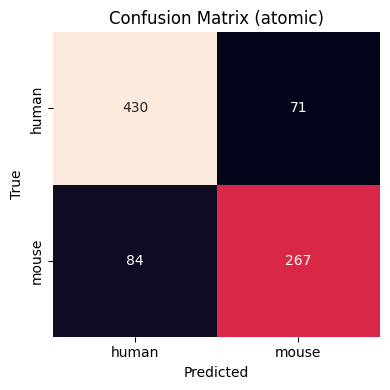

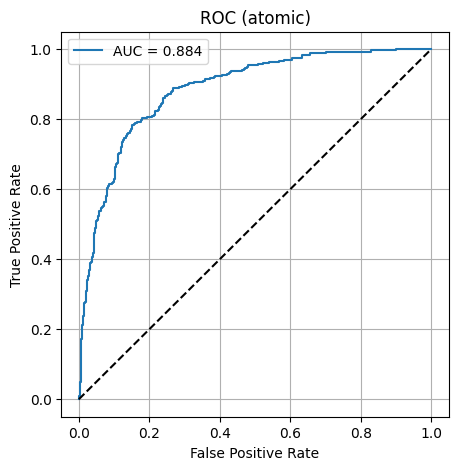



Encoding: eiip


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 2000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 500, 64)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 500, 128)  │     41,088 │ max_pooling1d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 125, 128)  │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_40    │ (None, 125, 128)  │     74,496 │ max_pooling1d_39… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_41    │ (None, 125, 128)  │     74,496 │ bidirectional_40… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_42    │ (None, 125, 64)   │     31,104 │ bidirectional_41… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     33,216 │ bidirectional_42… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_42… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 125, 64)   │          0 │ bidirectional_42… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 192)       │          0 │ dense_95[0][0],   │
│ (Concatenate)       │                   │            │ dense_96[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 128)       │     24,704 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ dense_97[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 300,801 (1.15 MB)

 Trainable params: 300,801 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6169 - auc: 0.6668 - loss: 0.8517 - val_accuracy: 0.6878 - val_auc: 0.8264 - val_loss: 0.6463
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7670 - auc: 0.8319 - loss: 0.5198 - val_accuracy: 0.6984 - val_auc: 0.8385 - val_loss: 0.6048
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7738 - auc: 0.8572 - loss: 0.4741 - val_accuracy: 0.7594 - val_auc: 0.8497 - val_loss: 0.4851
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7952 - auc: 0.8861 - loss: 0.4175 - val_accuracy: 0.7829 - val_auc: 0.8740 - val_loss: 0.4450
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8172 - auc: 0.8982 - loss: 0.3953 - val_accuracy: 0.7876 - val_auc: 0.8727 - val_loss: 0.4463
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8290 - auc: 0.9079 - loss: 0.3779 - val_accuracy: 0.7969 - val_auc: 0.8776 - val_loss: 0.4396
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms

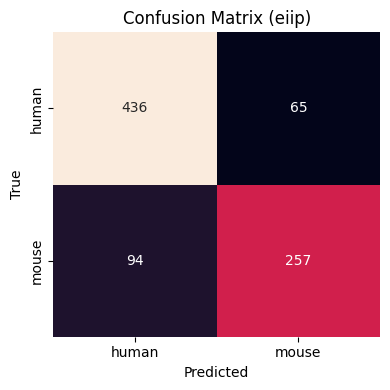

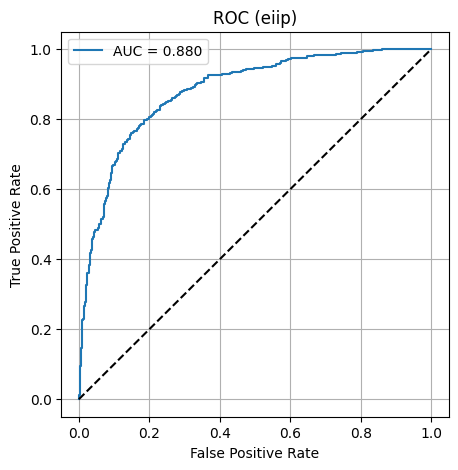



Encoding: bfdna


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 2000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 500, 64)   │          0 │ conv1d_40[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 500, 128)  │     41,088 │ max_pooling1d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 125, 128)  │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_43    │ (None, 125, 128)  │     74,496 │ max_pooling1d_41… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_44    │ (None, 125, 128)  │     74,496 │ bidirectional_43… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_45    │ (None, 125, 64)   │     31,104 │ bidirectional_44… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     33,216 │ bidirectional_45… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_45… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 125, 64)   │          0 │ bidirectional_45… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 192)       │          0 │ dense_100[0][0],  │
│ (Concatenate)       │                   │            │ dense_101[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 128)       │     24,704 │ concatenate_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 128)       │          0 │ dense_102[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 300,801 (1.15 MB)

 Trainable params: 300,801 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.6764 - auc: 0.7397 - loss: 0.6467 - val_accuracy: 0.7582 - val_auc: 0.8478 - val_loss: 0.5229
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7534 - auc: 0.8421 - loss: 0.4917 - val_accuracy: 0.7700 - val_auc: 0.8557 - val_loss: 0.5199
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7804 - auc: 0.8643 - loss: 0.4556 - val_accuracy: 0.7418 - val_auc: 0.8505 - val_loss: 0.5483
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7891 - auc: 0.8707 - loss: 0.4441 - val_accuracy: 0.7840 - val_auc: 0.8684 - val_loss: 0.4601
Epoch 5/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8033 - auc: 0.8932 - loss: 0.4032 - val_accuracy: 0.8040 - val_auc: 0.8771 - val_loss: 0.4312
Epoch 6/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8256 - auc: 0.9027 - loss: 0.3865 - val_accuracy: 0.8040 - val_auc: 0.8815 - val_loss: 0.4293
Epoch 7/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms

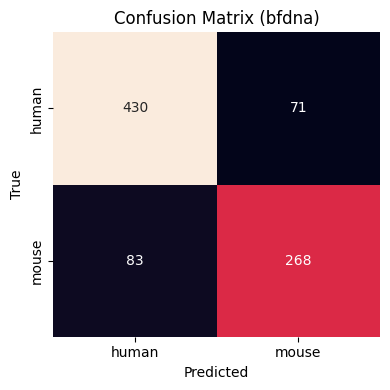

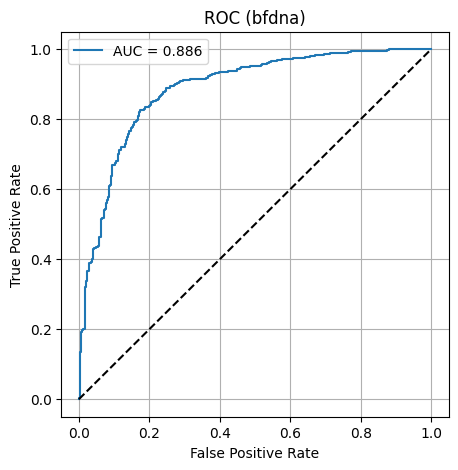

In [ ]:
encodings = ["integer", "atomic", "eiip", "bfdna"]
all_results = {}

for scheme in encodings:
    print("\n\n==============================")
    print("Encoding:", scheme)
    print("==============================")

    X_seq = encode_sequences(sequences, scheme)
    input_seq_shape = X_seq.shape[1:]

    X_seq_train = X_seq[train_idx]
    X_seq_val   = X_seq[val_idx]
    X_seq_test  = X_seq[test_idx]

    y_train_split = y[train_idx]
    y_val_split   = y[val_idx]
    y_test_split  = y[test_idx]

    model = build_hybrid_model(input_seq_shape, feat_dim)
    model.summary()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    if scheme == "bfdna":
        current_epochs = 60
    else:
        current_epochs = 20
    history = model.fit(
        [X_seq_train, X_feats_train], y_train_split,
        validation_data=([X_seq_val, X_feats_val], y_val_split),
        epochs = current_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop]
    )

    y_prob_test = model.predict([X_seq_test, X_feats_test]).ravel()
    metrics = compute_metrics_binary(y_test_split, y_prob_test)
    all_results[scheme] = metrics

    print("\nTest metrics for", scheme)
    for k, v in metrics.items():
        if k == "CM":
            continue
        print(f"{k:>10}: {v:.4f}")

    plot_confusion(metrics["CM"], f"Confusion Matrix ({scheme})")
    plot_roc(y_test_split, y_prob_test, f"ROC ({scheme})")

In [ ]:
rows = []
for scheme, m in all_results.items():
    rows.append({
        "Encoding": scheme,
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1-score": m["f1"],
        "CSI": m["CSI"],
        "G-mean": m["G-mean"],
        "MCC": m["MCC"],
        "Kappa": m["Kappa"],
        "AUC": m["AUC"],
    })

df_results = pd.DataFrame(rows)
print("\nSummary (Scenario 1, GRU+Attn+Features):")
print(df_results.to_string(index=False, float_format=lambda x: f"{x*100:5.2f}%"))



Summary (Scenario 1, GRU+Attn+Features):
Encoding  Accuracy  Precision  Recall  F1-score    CSI  G-mean    MCC  Kappa    AUC
 integer    80.40%     77.06%  74.64%    75.83% 51.70%  79.39% 59.37% 59.35% 87.20%
  atomic    81.81%     78.99%  76.07%    77.50% 55.06%  80.80% 62.27% 62.24% 88.37%
    eiip    81.34%     79.81%  73.22%    76.37% 53.03%  79.82% 61.15% 61.00% 88.02%
   bfdna    81.92%     79.06%  76.35%    77.68% 55.41%  80.95% 62.53% 62.50% 88.64%
